In [2]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import brentq
from scipy.interpolate import griddata
import os
import seaborn as sns

sns.set_style('whitegrid')

n_m = 10
n_mu = 10
m_sample = np.geomspace(1e-2,2,n_m)
mu_sample = np.geomspace(1e-7,1e-5,n_mu)
m_sample, mu_sample = np.meshgrid(m_sample, mu_sample)
m_sample = np.reshape(m_sample,[n_m*n_mu])
mu_sample = np.reshape(mu_sample,[n_m*n_mu])

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica", "sans-serif"],
    "mathtext.fontset": "dejavusans",
    'font.size': 16,
    'image.cmap': 'YlGnBu',
})

POT = {}
bkg = {}

# POT used in MC simulation
POT['ND280+_MC'] = 2.6098758621e22
POT['ND280_MC'] = 3.6e21

# POT in Abe et al 2019
POT['ND280_nu_2019'] = 1.234e21
POT['ND280_nubar_2019'] = 6.29e20

POT['ND280_nu_2023'] = 19.7e20
POT['ND280_nubar_2023'] = 16.3e20

# POT Events conducted in ND280+
# 1E22 is cumulative
POT['ND280+_nu'] = 1e22 - POT['ND280_nu_2023'] 
POT['ND280+_nubar'] = 1e22 - POT['ND280_nubar_2023']


# TPC e+e- background from Abe et al 2019
bkg['ND280_nu_2019'] = 0.563
bkg['ND280_nubar_2019'] = 0.015 

bkg['ND280+_nu'] = bkg['ND280_nu_2019'] * 5 / 3 * POT['ND280+_nu'] / POT['ND280_nu_2019'] 
bkg['ND280+_nubar'] = bkg['ND280_nubar_2019']* 5 / 3 * POT['ND280+_nubar'] / POT['ND280_nu_2019'] 

bkg['ND280_nu_2023'] = bkg['ND280_nu_2019'] * 5 / 3 * POT['ND280_nu_2023'] / POT['ND280_nu_2019'] 
bkg['ND280_nubar_2023'] = bkg['ND280_nubar_2019']* 5 / 3 * POT['ND280_nubar_2023'] / POT['ND280_nu_2019'] 

In [3]:
POT_weight = POT['ND280+_nu']/POT['ND280+_MC']
POT_weight_OG = POT['ND280_nu_2023']/POT['ND280_MC']


def BR(m):
    alpha = 1/137 # Fine structure constant
    me = 0.511e-3 # Electron mass in GeV
    r = me/m
    L = lambda r:(2 - r**6 * 0.125) * np.arccosh(1/r) - (24 - 10 * r**2 + r**4) * 0.125 * np.sqrt(1 - 4*r**2)
    return np.array(alpha * L(r) / (3 * np.pi))

def get_data_csv(scale='log', year=3, exp='ND280+', mode = 'nu'):
    
    '''
    Scale = ['log' or 'linear']
    Year = 0, 1, 2, 3 only applies to ND280+ projection
    Mode = ['nu', 'nubar']
    '''
    
    if exp == 'ND280+' and mode == 'nu':
        path='../stats/signal_strengths.csv'
    elif exp == 'ND280' and mode == 'nu':
        path='../stats/signal_strengths_nd280.csv'
    elif exp == 'ND280+' and mode == 'nubar':
        path='../stats/signal_strengths_nubar.csv'
    elif exp == 'ND280' and mode == 'nubar':
        path='../stats/signal_strengths_nd280_nubar.csv'    
        
    df = pd.read_csv(path).sort_values(['Experiment', 'i'])
    grouped = df.groupby('Experiment')
    
    signal_strengths = {exp: group.drop(['Experiment', 'i'], axis=1).to_numpy() 
                        for exp, group in grouped}
    
    last_exp = list(signal_strengths.keys())[-1]
    mass = signal_strengths[last_exp][:, 0]
    coupling = signal_strengths[last_exp][:, 1]
    
    total_signal_strengths = np.sum([arr[:, 2] for arr in signal_strengths.values()], axis=0)
    
    # Downweight by branching ratio
    total_signal_strengths *= BR(mass)
    
    # Scale by respective POT
    if exp == 'ND280+':
        if mode =='nu':
            ratio = POT['ND280+_nu']/POT['ND280+_MC'] * year / 3 
        else:
            ratio = POT['ND280+_nubar']/POT['ND280+_MC'] * year / 3

    elif exp == 'ND280':
        if mode =='nu':
            ratio = POT['ND280_nu_2019']/POT['ND280_MC']
        else:
            ratio = POT['ND280_nubar_2019']/POT['ND280_MC']
            
    total_signal_strengths *= ratio
    
    # COUPLING/2 = TMM 
    if scale == 'log':
        return (np.log10(mass * 1000), np.log10(coupling / 2), np.log10(total_signal_strengths))
    return (np.log10(mass * 1000), np.log10(coupling / 2), total_signal_strengths)

signal_threshold = {}

def logLR(z, key='ND280+_nu'):
    return np.absolute(z - (bkg[key]+z) * np.log(1 + z/bkg[key]))

# 95% Confidence Level
def tar(cl):
    return 0.5 * stats.norm.ppf(1-cl)**2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

# Constants
HBAR = 1.0545718e-34  # Reduced Planck constant (J·s)
C = 2.998e8  # Speed of light (m/s)
HBAR_C2 = HBAR * C**2

def calculate_decay_distance(E, mN, mu):
    return (16 * np.pi * np.sqrt(((E/mN)**2-1))) / (mu**2 * mN**3) * HBAR_C2

def weighted_median_decay_distance_vectorized(energies, weights, M, Mu):
    mask = energies >= M
    filtered_energies = energies[mask]
    filtered_weights = weights[mask]
    
    if len(filtered_energies) == 0:
        return np.nan
    
    decay_distances = calculate_decay_distance(filtered_energies[:, np.newaxis], M, Mu)
    sorted_indices = np.argsort(decay_distances, axis=0)
    sorted_distances = np.take_along_axis(decay_distances, sorted_indices, axis=0)
    sorted_weights = np.take_along_axis(filtered_weights[:, np.newaxis], sorted_indices, axis=0)
    
    cumulative_weights = np.cumsum(sorted_weights, axis=0)
    total_weight = cumulative_weights[-1]
    median_index = np.searchsorted(cumulative_weights.ravel(), total_weight / 2)
    
    return sorted_distances[median_index]

def plot_decay_distance_heatmap(m_range, mu_range, num_points=100, num_contours=10):
    # Load data once
    data = np.loadtxt('flux.dat')
    energies, weights = data[:, 0], data[:, 1]
    
    # Create logarithmically spaced points for m and mu
    m_values = np.geomspace(m_range[0], m_range[1], num_points)
    mu_values = np.geomspace(mu_range[0], mu_range[1], num_points)
    
    # Create meshgrid for m and mu
    M, MU = np.meshgrid(m_values, mu_values)
    
    # Vectorized calculation of decay distances
    distances = np.frompyfunc(lambda m, mu: weighted_median_decay_distance_vectorized(energies, weights, m, mu), 2, 1)(M, MU).astype(float)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create the heatmap
    im = ax.pcolormesh(m_values, mu_values, distances, norm=LogNorm(), shading='auto')
    
    # Add contour lines
    levels = [1, 10]
    contour = ax.contour(M, MU, distances, levels=levels, colors='white', alpha=1)
    ax.clabel(contour, inline=True, fontsize=14, fmt='%.1e')
    
    # Save contour data
    with open('analytic_distance_contour_test.txt', 'w') as f:
        for i, collection in enumerate(contour.collections):
            for path in collection.get_paths():
                vertices = path.vertices
                f.write(f"Contour Level: {levels[i]}\n")
                np.savetxt(f, vertices, fmt='%.16f', delimiter='\t')
                f.write("\n")
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, label='Decay Distance (m)')
    cbar.ax.yaxis.set_tick_params(which='both', direction='out')
    
    # Set scale and labels
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('m (GeV)')
    ax.set_ylabel('$\mu_{tr}$')
    ax.set_title('Weighted Median Decay Distance')
    
    plt.tight_layout()
    plt.show()

# Example usage
m_range = (6e-2, 2)  # GeV
mu_range = (1e-7, 1e-5)  # mu
plot_decay_distance_heatmap(m_range, mu_range, num_points=500)

<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3489670/572091181.py:76: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_{tr}$')


<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3492729/3175311133.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)
/tmp/ipykernel_3492729/3175311133.py:16: RuntimeWarning: invalid value encountered in log10
  y = np.log10(y/2)
/tmp/ipykernel_3492729/3175311133.py:48: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)


ValueError: Axis limits cannot be NaN or Inf

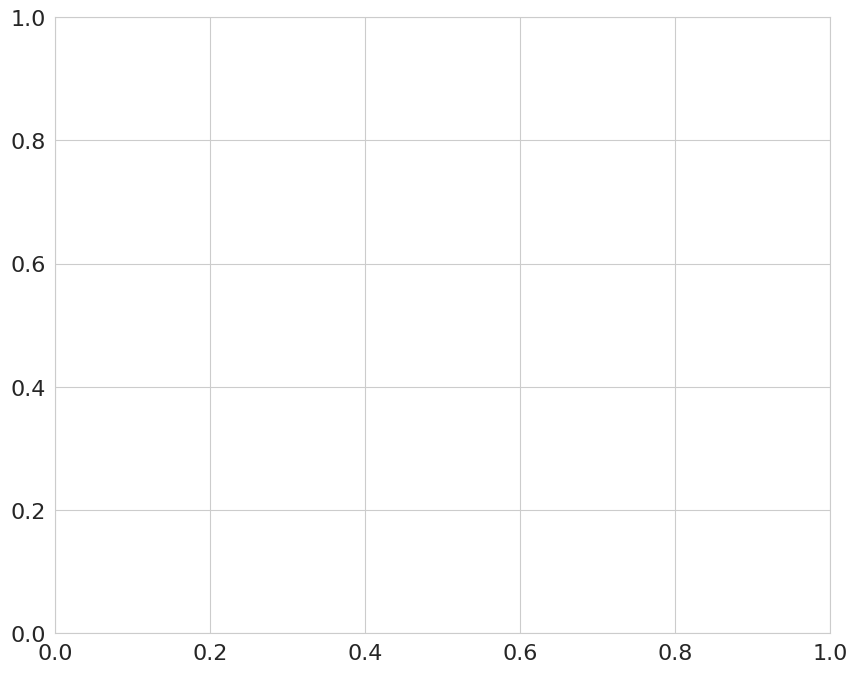

In [5]:

def process_contour_data(file_path):
    contours = {}
    current_level = None
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('Contour Level:'):
                current_level = float(line.split(':')[1])
                contours[current_level] = []
            elif line.strip() and current_level is not None:
                x, y = map(float, line.split())
                contours[current_level].append((x, y))
    return {level: np.array(points) for level, points in contours.items()}

def distance_pixel_plot(x, y, z, line_intercept=0, contour_file=None):
    x = np.log10(x*1000)
    y = np.log10(y/2)
    x_unique, y_unique = np.unique(x), np.unique(y)
    z_grid = np.full((len(y_unique), len(x_unique)), np.nan)
    
    for xi, yi, zi in zip(x, y, z):
        x_idx = np.searchsorted(x_unique, xi)
        y_idx = np.searchsorted(y_unique, yi)
        z_grid[y_idx, x_idx] = zi
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid, origin='lower', extent=[x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()],
                   aspect='auto', norm=LogNorm())
    
    cbar = plt.colorbar(im, label='Decay Distance (m)', format='%1.0e')
    cbar.ax.yaxis.label.set_rotation(270)
    cbar.ax.yaxis.label.set_va('bottom')
    cbar.ax.yaxis.labelpad = 15
    
    if contour_file:
        contours = process_contour_data(contour_file)
        for level, points in contours.items():
            X = np.log10(points[:, 0]*1000)
            Y = np.log10(points[:, 1]/2)
            ax.plot(X, Y, 'w--', linewidth=1.5)
            mid_point = len(X) // 2
            ax.annotate(f'{level:.1f} m', (X[mid_point], Y[mid_point]),
                        color='white', fontweight='bold', fontsize=10,
                        xytext=(3, 3), textcoords='offset points', rotation=295,
                        bbox=dict(facecolor='none', alpha=0.5, edgecolor='none'))
    
    ax.set_xlabel(r'$log_{10}(m/MeV)$', fontsize=16)
    ax.set_ylabel(r'$log_{10}(d_{\nu N})$', fontsize=16)
    ax.set_title('$\mathcal{N}$ Decay Distance', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Set y-axis limits
    y_min, y_max = y_unique.min(), y_unique.max()
    y_range = y_max - y_min
    plt.ylim(y_min, y_max + y_range * 0.05)  # Add 5% padding at the top
    
    plt.tighcd t_layout()
    plt.show()

x, y, z = get_data_csv()
z = logLR(z)
distance_pixel_plot(x, y, z, line_intercept=2, contour_file='analytic_distance_contour.txt')